In [31]:
%load_ext autoreload
%autoreload 2
#  base environment
from notebook_setup import *

import os
import dotenv
import numpy as np
import functools

# noise generation
from noise import pnoise2, pnoise3
from joblib import Parallel, delayed

# visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings

# load environment variables
_ = dotenv.load_dotenv(override=True)

from training.networks.neuraloperator.multipole import MPGKScoreOperator
from data.synthetic.low_frequency import PinkNoise1D
from training.noising_kernels import RBFIrregular
from training.collate import CollateMesh, CompositeCollate, MakeConditional
from training.networks.neuraloperator.multipole import MPGKScoreOperator
from training.loss import EDMLoss
from training.augment_pipe import AugmentPipe
from samplers import EDMSampler, EulerSampler
from training.networks.neuraloperator.precond import EDMPreconditioner
import datetime
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Denoising Operators

Here, we aim to generate stochastic processes with the real line as the domain. We will use the multipole denoising operator and train it with a denoising diffusion loss. For the base stochastic process, we will a pink noise process composed with a low pass filter to generate functions with low frequency characteristics.


Run the following to first sample from this stochastic process and look at what the original functions (that we aim to generate) look like:


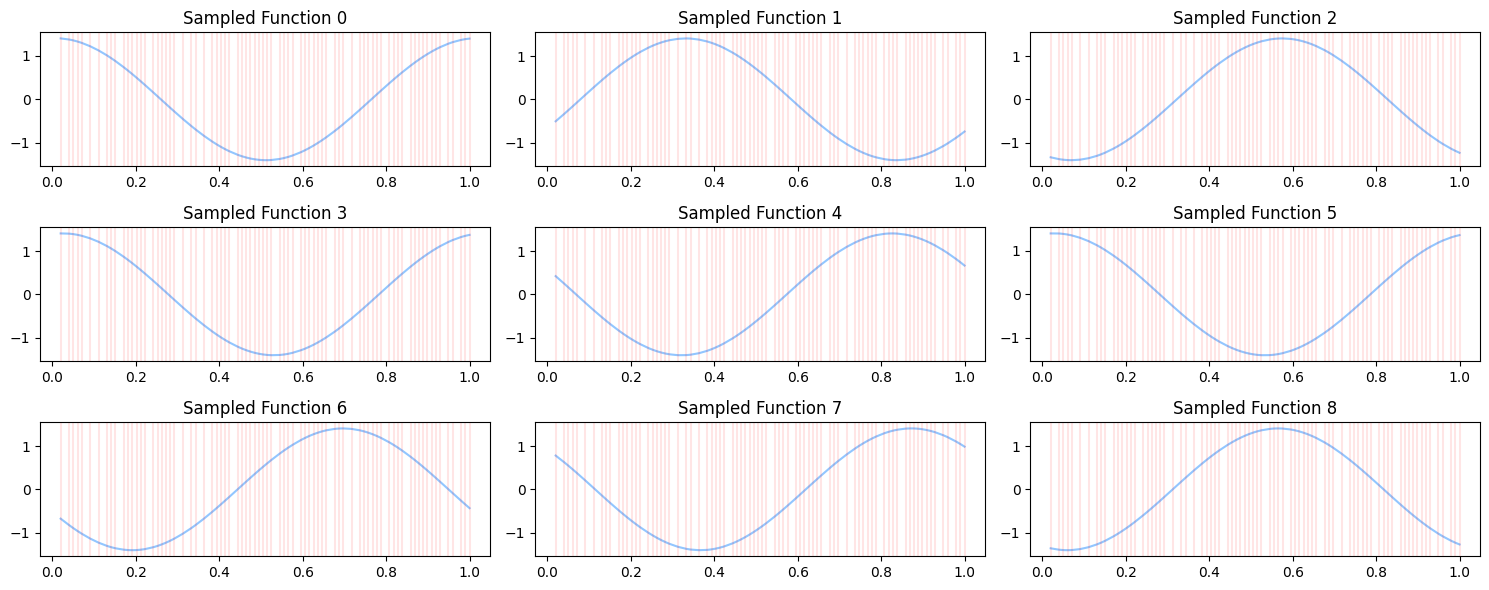

In [21]:
dset = PinkNoise1D(
    total_count=5000,
    num_samples=100,
    low_pass_threshold=0.02,
    make_irregular=True,
    bernoulli_p=0.8,
    fixed_irregularity_seed=42,
)
# plot 9 first samples of the dataset
fig, axes = plt.subplots(3, 3, figsize=(15, 6))
for i in range(9):
    ax = axes[i // 3, i % 3]
    coords, intensities = dset[i]
    ax.plot(coords.squeeze(), intensities.squeeze())
    ax.set_title(f"Function {i} in the Dataset")
    # add small vertical lines on each coords 
    for x in coords.squeeze():
        ax.axvline(x, color="red", alpha=0.1)
plt.tight_layout()

Train a denoising diffusion operator using the denoising loss.


loading checkpoint ...
resuming progress ...


100%|██████████| 1000/1000 [00:00<00:00, 2191381.40it/s]


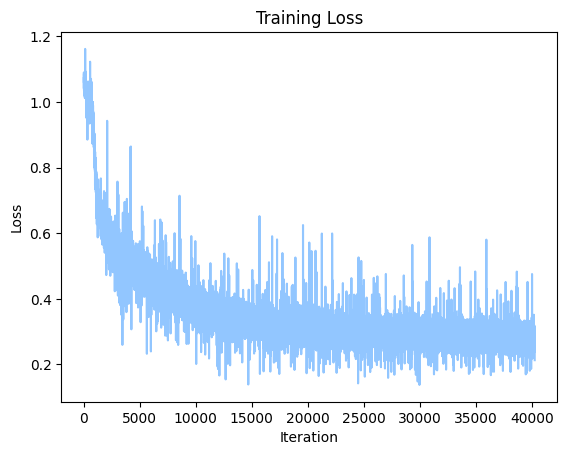

In [136]:
num_epochs = 1000
batch_size = 128
sigma_min = 0.0002
sigma_max = 80
saving_prefix = "less_expressive" # set to something catchy if you like
checkpoint_name = "less_expressive-29Oct-1620" # set to some value for checkpointing
resume = True
learning_rate = 1e-5
total_epoch = 0
####

noising_kernel = RBFIrregular()
dloader = DataLoader(dset, batch_size=batch_size, collate_fn=CompositeCollate([MakeConditional(), CollateMesh()]))
# get the standard deviation of data
for (coords, intensities), conditioning in dloader:
    sigma_data = torch.std(intensities).item()
    break
denoiser_network = MPGKScoreOperator(
    coord_dim=1,
    latent_channels=32, # 128
    radius=0.01,
    radii_mult=[2, 4, 8],
    iter_count=3, # 8
)
# precondition the network for better performance
denoiser_network = EDMPreconditioner(
    score_net=denoiser_network,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    sigma_data=sigma_data,
)
optim = torch.optim.Adam(denoiser_network.parameters(), lr=learning_rate)
####

all_loss_history = []
total_epoch = 0
original_epoch = 0
if checkpoint_name is not None and (
    os.path.exists(f"outputs/checkpoints/notebooks/{checkpoint_name}/denoiser_model.pth") and
    os.path.exists(f"outputs/checkpoints/notebooks/{checkpoint_name}/optim_model.pth") and
    os.path.exists(f"outputs/checkpoints/notebooks/{checkpoint_name}/history.pkl") and 
    os.path.exists(f"outputs/checkpoints/notebooks/{checkpoint_name}/total_epoch.txt")
):
    print("loading checkpoint ...")
    denoiser_network.load_state_dict(torch.load(f"outputs/checkpoints/notebooks/{checkpoint_name}/denoiser_model.pth", weights_only=True))
    optim.load_state_dict(torch.load(f"outputs/checkpoints/notebooks/{checkpoint_name}/optim_model.pth"))
    all_loss_history = pickle.load(open(f"outputs/checkpoints/notebooks/{checkpoint_name}/history.pkl", "rb"))
    original_epoch = int(open(f"outputs/checkpoints/notebooks/{checkpoint_name}/total_epoch.txt", "r").read())

if checkpoint_name is None or resume:
    try:
        if resume:
            print("resuming progress ...")
        loss_fn = EDMLoss(
            noising_kernel=noising_kernel,
            P_mean=-1.2, 
            P_std=1.2, 
            sigma_data=sigma_data,
        )
        # TODO: fix Suppress all warnings
        warnings.filterwarnings("ignore")
        pbar = tqdm(range(num_epochs))
        # set the start to total_epoch if resuming
        if resume and original_epoch > 0:
            for _ in range(original_epoch):
                pbar.update(1)
        for epoch in range(num_epochs - original_epoch):
            for (coords, intensities), conditioning in dloader:
                # zero grad
                optim.zero_grad()

                # sample noise
                loss = loss_fn(
                    net=denoiser_network, 
                    coords=coords,
                    samples=intensities,
                    conditioning=conditioning,
                    augment_pipe=AugmentPipe(),
                ).mean()
                loss.backward()
                all_loss_history.append(loss.item())
                optim.step()
                pbar.set_description(f"Loss: {loss.item():.3f}")
            total_epoch += 1
            pbar.update(1)
    finally:

        if total_epoch > 0:
            print("saving progress ...")
            now = datetime.datetime.now()
            # format data and year and hour and minute
            formatted_name = now.strftime("%d%b-%H%M")
            if saving_prefix is not None:
                formatted_name = f"{saving_prefix}-{formatted_name}"
            os.makedirs(f"outputs/checkpoints/notebooks/{formatted_name}", exist_ok=True)
            torch.save(denoiser_network.state_dict(), f"outputs/checkpoints/notebooks/{formatted_name}/denoiser_model.pth")
            torch.save(optim.state_dict(), f"outputs/checkpoints/notebooks/{formatted_name}/optim_model.pth")
            with open(f"outputs/checkpoints/notebooks/{formatted_name}/history.pkl", "wb") as f:
                pickle.dump(all_loss_history, f)
            with open(f"outputs/checkpoints/notebooks/{formatted_name}/total_epoch.txt", "w") as f:
                f.write(str(total_epoch + original_epoch))
        pbar.close()
        plt.plot(all_loss_history)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()


Sampling: 100%|██████████| 30/30 [00:09<00:00,  3.01it/s]


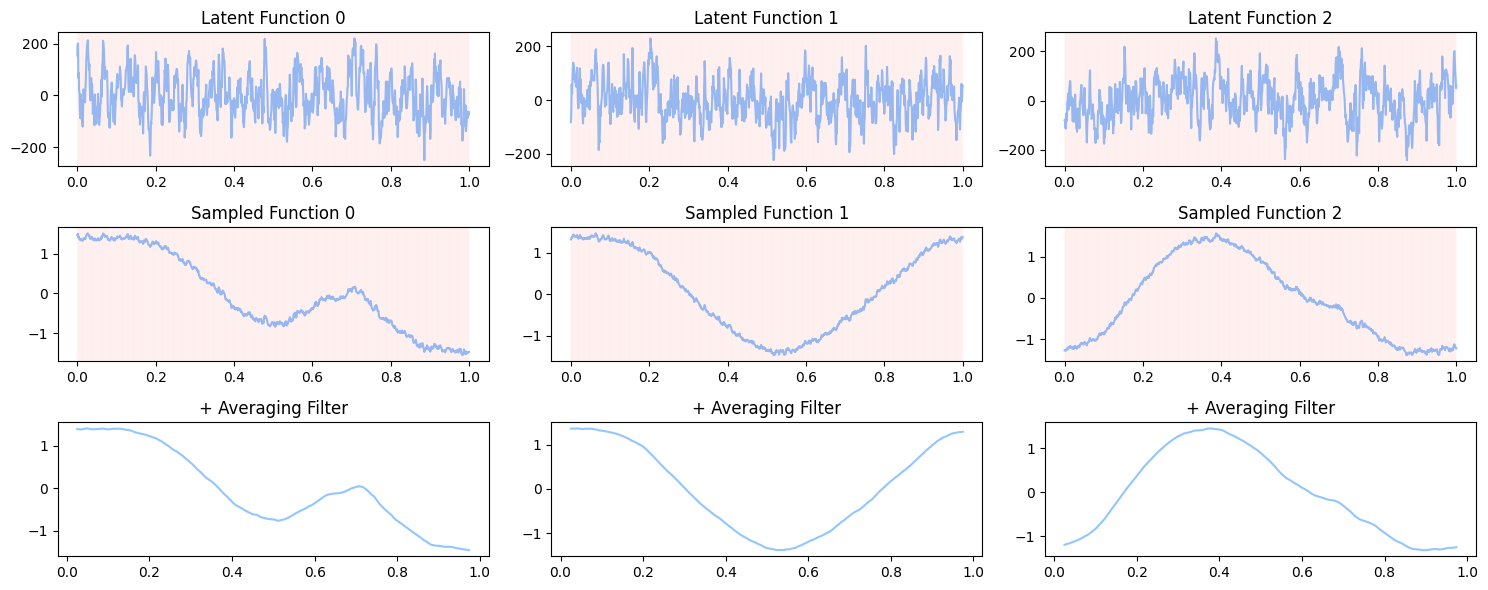

In [137]:
num_steps = 30
batch_size = 3
rho = 7
resolution = 1000
generation_seed=42
###

torch.random.manual_seed(generation_seed)
generation_coords = torch.linspace(0, 1, resolution).unsqueeze(0)
# print(generation_coords.shape, coords.shape)

sampler = EDMSampler(verbose=True)
with torch.no_grad():
    latents = sigma_max * noising_kernel.sample(
        coords=generation_coords.unsqueeze(0).repeat(batch_size, 1, 1),
    )
    samples = sampler(
        net=denoiser_network,
        coords=generation_coords,
        latents=latents,
        conditioning=None,
        num_steps=num_steps, 
        sigma_min=sigma_min, 
        sigma_max=sigma_max, 
        rho=rho,
    )
    fig, axes = plt.subplots(3, batch_size, figsize=(15, 6))
    for i in range(batch_size):
        ax = axes[0, i]
        ax.plot(generation_coords.squeeze(), latents[i].squeeze())
        ax.set_title(f"Latent Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        ax = axes[1, i]
        ax.plot(generation_coords.squeeze(), samples[i].squeeze())
        ax.set_title(f"Sampled Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        # pass samples[i] through an average filter
        ax = axes[2, i]
        radius = 0.05
        window_size = 2 * int(radius * resolution / 2) + 1
        samples_smoothed = torch.nn.functional.avg_pool1d(samples[i].unsqueeze(0), window_size, stride=1, padding=window_size // 2).squeeze()
        smoothed_coords = generation_coords.squeeze()
        # print(samples_smoothed.shape, smoothed_coords.shape)
        ax.plot(generation_coords.squeeze()[window_size // 2:-window_size // 2], samples_smoothed[window_size // 2:-window_size // 2])
        ax.set_title(f"+ Averaging Filter")
    plt.tight_layout()